In [37]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import copy
from scipy.interpolate import griddata

In [38]:
NU = 0.001

In [39]:
# Krok 1.1: Definice modelu neuronové sítě 
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Vstup je 2D, proto 2 vstupy (x,y)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(20, 20)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(20, 20)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(20, 20)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(20, 20)
        self.tanh5 = nn.Tanh()
        self.fc6 = nn.Linear(20, 2)  # Výstup je psi, p

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.tanh2(x)
        x = self.fc3(x)
        x = self.tanh3(x)
        x = self.fc4(x)
        x = self.tanh4(x)
        x = self.fc5(x)
        x = self.tanh5(x)
        x = self.fc6(x)
        return x

In [40]:
def generate_inner_train_data(no_points): # Body uvnitř oblasti
    x = torch.linspace(0+1e-3, 2.2-1e-3, int(torch.sqrt(torch.tensor(no_points)))) 
    y = torch.linspace(0+1e-3, 0.41-1e-3, int(torch.sqrt(torch.tensor(no_points)))) 
    X, Y = torch.meshgrid(x, y)

    x = X.reshape(-1, 1)
    y = Y.reshape(-1, 1)
    
    circle_center = torch.tensor([0.2, 0.2])
    circle_radius = 0.05

    # Condition to exclude points inside the circle
    points_in = (x - circle_center[0])**2 + (y - circle_center[1])**2 > circle_radius**2

    x_train = x[points_in].view(-1, 1)
    y_train = y[points_in].view(-1, 1)

    return (x_train, y_train)

def generate_boundaries(no_points): # Body na hranici
    x_bottom = torch.linspace(0,2.2, no_points).view(-1, 1)
    y_bottom = torch.zeros_like(x_bottom)
    y_left = torch.linspace(0, 0.41, no_points).view(-1, 1)
    x_left = torch.zeros_like(y_left)
    y_right = torch.linspace(0, 0.41, no_points).view(-1,1)
    x_right = 2.2*torch.ones_like(y_right)
    x_top = torch.linspace(0, 2.2, no_points).view(-1, 1)
    y_top = 0.41*torch.ones_like(x_top)
    # Circular boundary (excluding region)
    theta = torch.linspace(0,  2 * np.pi, no_points).view(-1, 1)  # Angles around the circle
    circle_center = torch.tensor([0.2, 0.2])
    circle_radius = 0.05

    x_circle = circle_center[0] + circle_radius * torch.cos(theta)
    y_circle = circle_center[1] + circle_radius * torch.sin(theta)

    return (x_bottom, y_bottom, x_top, y_top, x_left, y_left, x_right, y_right, x_circle, y_circle)

def plot_boundaries(x_train, y_train, x_bottom, y_bottom, x_top, y_top, x_left, y_left,x_right, y_right, x_circle, y_circle):
    plt.figure(figsize=(24, 6))
    plt.scatter(x_bottom.numpy(), y_bottom.numpy(), label="Dolní",s=5, color='blue')
    plt.scatter(x_top.numpy(), y_top.numpy(), label="Horní",s=5, color='green')
    plt.scatter(x_left.numpy(), y_left.numpy(), label="Levé",s=5, color='red')
    plt.scatter(x_circle.numpy(), y_circle.numpy(), label="Váleček",s=5, color='magenta')
    plt.scatter(x_right.numpy(), y_right.numpy(), label="Pravé",s=5, color='orange')
    plt.scatter(x_train.numpy(), y_train.numpy(), label="Vnitřní",s=10, color='yellow')
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.title("Trénovací data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()
    return

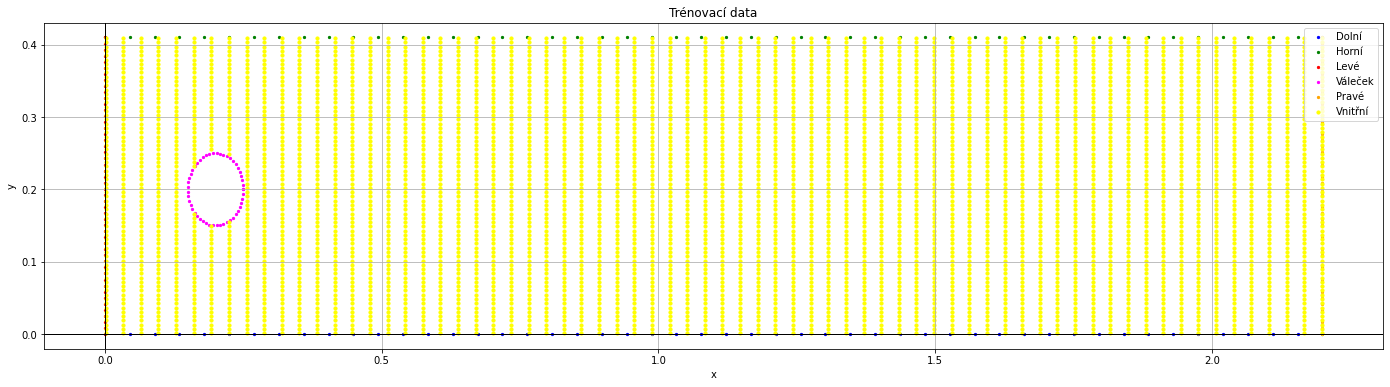

In [41]:
x_train, y_train = generate_inner_train_data(5000)
x_bottom, y_bottom, x_top, y_top, x_left, y_left, x_right, y_right, x_circle, y_circle = generate_boundaries(50)
plot_boundaries(x_train, y_train, x_bottom, y_bottom, x_top, y_top, x_left, y_left, x_right, y_right, x_circle, y_circle)

In [42]:
def compute_derivatives_2d(model, x, y): # Výpočet derivací pomocí funkce autograd z knihovny PyTorch
    inputs = torch.hstack((x,y)).requires_grad_(True)
    outputs = model(inputs)
    psi, p = outputs[:, 0], outputs[:, 1]
    
    # První derivace
    v = -grad(psi, inputs, torch.ones_like(psi), create_graph=True)[0][:, 0:1]  # du/dx
    u = grad(psi, inputs, torch.ones_like(psi), create_graph=True)[0][:, 1:2]  # du/dy
    u_x = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 0:1]  # du/dx
    u_y = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 1:2]  # du/dy
    v_x = grad(v, inputs, torch.ones_like(v), create_graph=True)[0][:, 0:1]  # du/dx
    v_y = grad(v, inputs, torch.ones_like(v), create_graph=True)[0][:, 1:2]  # du/dy
    p_x = grad(p, inputs, torch.ones_like(p), create_graph=True)[0][:, 0:1]  # du/dx
    p_y = grad(p, inputs, torch.ones_like(p), create_graph=True)[0][:, 1:2]  # du/dy
    
    # Druhé derivace
    v_xx = grad(v_x, inputs, torch.ones_like(v_x), create_graph=True)[0][:, 0:1]  # d²u/dx²
    v_yy = grad(v_y, inputs, torch.ones_like(v_y), create_graph=True)[0][:, 1:2]  # d²u/dy²
    u_xx = grad(u_x, inputs, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]  # d²u/dx²
    u_yy = grad(u_y, inputs, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]  # d²u/dy²
    
    return (psi, p, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y)

In [43]:
def compute_loss(model, x_train, y_train, x_bottom, y_bottom, x_top, y_top, x_left, y_left, x_right, y_right, x_circle, y_circle):
    # PDR ztráta
    psi, p, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y = compute_derivatives_2d(model, x_train, y_train) # Výpočet derivací
    pde_1_loss = torch.mean((u * u_x + v * u_y + p_x - NU * (u_xx + u_yy))**2)
    pde_2_loss = torch.mean((u * v_x + v * v_y + p_y - NU * (v_xx + v_yy))**2)
    
    # Ztráta na hranici
    inputs_left = torch.hstack((x_left,y_left)).requires_grad_(True)
    outputs_left = model(inputs_left)
    psi_left = outputs_left[:, 0]
    v_left = -1*grad(psi_left, inputs_left, torch.ones_like(psi_left), create_graph=True)[0][:, 0:1]  # du/dx
    u_left = grad(psi_left, inputs_left, torch.ones_like(psi_left), create_graph=True)[0][:, 1:2]  # du/dy

    inputs_right = torch.hstack((x_right,y_right)).requires_grad_(True)
    outputs_right = model(inputs_right)
    psi_right, p_right = outputs_right[:, 0], outputs_right[:, 1]
    v_right = -1*grad(psi_right, inputs_right, torch.ones_like(psi_right), create_graph=True)[0][:, 0:1]  # du/dx
    u_right = grad(psi_right, inputs_right, torch.ones_like(psi_right), create_graph=True)[0][:, 1:2]  # du/dy
    u_x_right = grad(u_right, inputs_right, torch.ones_like(u_right), create_graph=True)[0][:, 0:1]  # du/dy
    v_x_right = grad(v_right, inputs_right, torch.ones_like(v_right), create_graph=True)[0][:, 0:1]  # du/dy

    inputs_top = torch.hstack((x_top, y_top)).requires_grad_(True)
    outputs_top = model(inputs_top)
    psi_top = outputs_top[:, 0]
    v_top = -1*grad(psi_top, inputs_top, torch.ones_like(psi_top), create_graph=True)[0][:, 0:1]  # du/dx
    u_top = grad(psi_top, inputs_top, torch.ones_like(psi_top), create_graph=True)[0][:, 1:2]  # du/dy

    inputs_bottom = torch.hstack((x_bottom, y_bottom)).requires_grad_(True)
    outputs_bottom = model(inputs_bottom)
    psi_bottom = outputs_bottom[:, 0]
    v_bottom = -1*grad(psi_bottom, inputs_bottom, torch.ones_like(psi_bottom), create_graph=True)[0][:, 0:1]  # du/dx
    u_bottom = grad(psi_bottom, inputs_bottom, torch.ones_like(psi_bottom), create_graph=True)[0][:, 1:2]  # du/dy

    inputs_circle = torch.hstack((x_circle, y_circle)).requires_grad_(True)
    outputs_circle = model(inputs_circle)
    psi_circle = outputs_circle[:, 0]
    v_circle = -1*grad(psi_circle, inputs_circle, torch.ones_like(psi_circle), create_graph=True)[0][:, 0:1]  # du/dx
    u_circle = grad(psi_circle, inputs_circle, torch.ones_like(psi_circle), create_graph=True)[0][:, 1:2]  # du/dy

    top_loss = torch.mean((u_top)**2+(v_top)**2)
    bottom_loss = torch.mean((u_bottom)**2+(v_bottom)**2)
    circle_loss = torch.mean((u_circle)**2+(v_circle)**2)

    u_inflow = ((4*0.3*y_left*(0.41-y_left))/(0.41**2))
    left_loss = torch.mean((u_left - u_inflow)**2 + v_left**2)
    right_loss = torch.mean((NU*u_x_right - p_right)**2) + torch.mean((NU*v_x_right)**2)

    # Celková ztráta
    total_loss = pde_1_loss + pde_2_loss + top_loss + bottom_loss + circle_loss + left_loss + right_loss
    return total_loss

In [44]:
def closure():
    optimizer.zero_grad()

    loss = compute_loss(model, x_train, y_train, x_bottom, y_bottom, x_top, y_top, x_left, y_left, x_right, y_right, x_circle, y_circle)

    loss.backward(retain_graph=True)
    return loss

In [45]:
model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=5e-3) 

In [46]:
epochs = 10000
best_model_state_dict = None
best_loss = float('inf')
loss_values = []
optim_change = epochs - 500
for epoch in range(epochs):
    if epoch <= optim_change:
        optimizer.zero_grad()
    
        # Výpočet ztráty
        loss = compute_loss(model, x_train, y_train, x_bottom, y_bottom, x_top, y_top, x_left, y_left, x_right, y_right, x_circle, y_circle)

        loss.backward() # Backward pass
        optimizer.step() # Optimalizace
    else:
        loss = optimizer.step(closure)

    if epoch == optim_change:
        model.load_state_dict(best_model_state_dict)
        optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, history_size=10)
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
        best_model_state_dict = copy.deepcopy(model.state_dict())
    loss_values.append(loss.detach().numpy())
    if (epoch + 1) % 500 == 0:
        print(f'Epocha {epoch+1}/{epochs}, Ztráta: {loss.item()}')


Epocha 500/10000, Ztráta: 0.016033491119742393
Epocha 1000/10000, Ztráta: 0.009538700804114342
Epocha 1500/10000, Ztráta: 0.008547624573111534
Epocha 2000/10000, Ztráta: 0.008103355765342712
Epocha 2500/10000, Ztráta: 0.005674639251083136
Epocha 3000/10000, Ztráta: 0.005255925003439188
Epocha 3500/10000, Ztráta: 0.004968848545104265
Epocha 4000/10000, Ztráta: 0.004556346219033003
Epocha 4500/10000, Ztráta: 0.0040863510221242905
Epocha 5000/10000, Ztráta: 0.003896992653608322
Epocha 5500/10000, Ztráta: 0.003918307367712259
Epocha 6000/10000, Ztráta: 0.003585531609132886
Epocha 6500/10000, Ztráta: 0.0027029034681618214
Epocha 7000/10000, Ztráta: 0.0021117907017469406
Epocha 7500/10000, Ztráta: 0.0018553758272901177
Epocha 8000/10000, Ztráta: 0.000874824938364327
Epocha 8500/10000, Ztráta: 0.0006978536839596927
Epocha 9000/10000, Ztráta: 0.0004987608990631998
Epocha 9500/10000, Ztráta: 0.0010418058373034
Epocha 10000/10000, Ztráta: 0.0001323146716458723


Nejlepší epocha 9719, Ztráta: 0.00013231464254204184


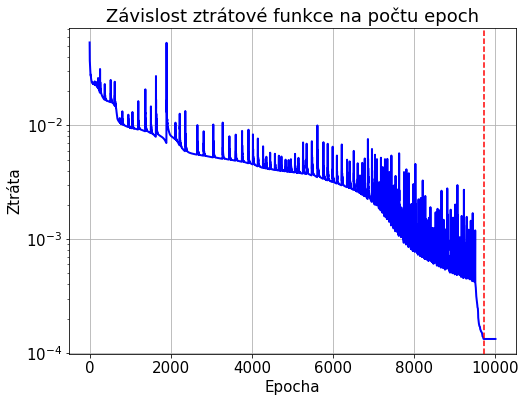

In [47]:
best_epoch = min(loss_values)
best_epoch_idx = loss_values.index(best_epoch)
print(f'Nejlepší epocha {best_epoch_idx}, Ztráta: {best_epoch}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_values, color='blue', linewidth=2)
plt.axvline(best_epoch_idx, color='r', linestyle='--', label='Nejlepší epocha')
plt.yscale('log')
plt.title('Závislost ztrátové funkce na počtu epoch', fontsize=18)
plt.xlabel('Epocha', fontsize=15)
plt.ylabel('Ztráta', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.show()

In [48]:
# Krok 1.6: Funkce pro vygenerování testovacích dat v oblasti (i na její hranici) a funkce pro jejich uspořádání
def generate_test_data_lhs(no_points):
    # Number of points inside the domain and on the boundary
    no_inside_points = int(no_points * 0.97)
    no_boundary_points = no_points - no_inside_points

    def latin_hypercube_sampling(num_samples, dim):
        """Generates Latin Hypercube Sampled points."""
        grid = torch.linspace(0, 1, num_samples + 1)[:-1].unsqueeze(1)
        grid = grid + (torch.rand(num_samples, dim) / num_samples)
        for d in range(dim):
            grid[:, d] = grid[torch.randperm(num_samples), d]
        return grid

    # Generate internal points
    lhs_inside = latin_hypercube_sampling(no_inside_points * 2, 2)  # Extra points to filter later
    x_inside = lhs_inside[:, 0:1] * 2.2  # Transform to (0,2.2)
    y_inside = lhs_inside[:, 1:2] * 0.41  # Transform to (0,0.41)
    
    # Exclude points inside the circle (centered at (0.2,0.2) with radius 0.05)
    mask = ((x_inside - 0.2) ** 2 + (y_inside - 0.2) ** 2) >= 0.05 ** 2
    x_inside, y_inside = x_inside[mask], y_inside[mask]
    
    # Keep only required number of points
    x_inside = x_inside[:no_inside_points].view(-1, 1)
    y_inside = y_inside[:no_inside_points].view(-1, 1)
    
    # Generate boundary points
    lhs_boundary = latin_hypercube_sampling(no_boundary_points, 1)
    side_assignments = torch.randint(0, 4, (no_boundary_points,))
    x_boundary = torch.zeros(no_boundary_points, 1)
    y_boundary = torch.zeros(no_boundary_points, 1)
    
    # Assign points to boundaries
    x_boundary[side_assignments == 0] = lhs_boundary[side_assignments == 0] * 2.2  # Top boundary
    y_boundary[side_assignments == 0] = 0.41

    x_boundary[side_assignments == 1] = lhs_boundary[side_assignments == 1] * 2.2  # Bottom boundary
    y_boundary[side_assignments == 1] = 0
    
    x_boundary[side_assignments == 2] = 0  # Left boundary
    y_boundary[side_assignments == 2] = lhs_boundary[side_assignments == 2] * 0.41
    
    x_boundary[side_assignments == 3] = 2.2  # Right boundary
    y_boundary[side_assignments == 3] = lhs_boundary[side_assignments == 3] * 0.41

    # Combine internal and boundary points
    x_test = torch.cat((x_inside, x_boundary.view(-1, 1)), dim=0)
    y_test = torch.cat((y_inside, y_boundary.view(-1, 1)), dim=0)
    
    return x_test, y_test

def sort_data(x_test, y_test):

    sorted_indices = torch.argsort(x_test.squeeze(), stable=True)

    x_test_sorted = x_test[sorted_indices]
    y_test_sorted = y_test[sorted_indices]

    return (x_test_sorted, y_test_sorted)

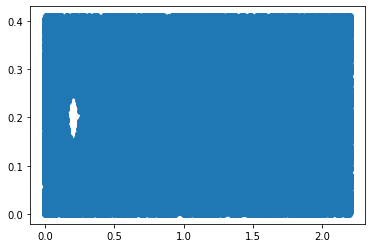

In [56]:
x_test, y_test = generate_test_data_lhs(20000) # Vygenerování testovacích dat
x_test.requires_grad_(True)
y_test.requires_grad_(True)
#x_test, y_test = sort_data(x_test, x_test) # Uspořádání testovacích dat
#with torch.no_grad():
inputs = torch.cat([x_test, y_test], dim=1)
outputs_pred = model(inputs) 
psi_pred, p_pred = outputs_pred[:, 0], outputs_pred[:, 1]
plt.scatter(x_test.detach().cpu().numpy().squeeze(), y_test.detach().cpu().numpy().squeeze())

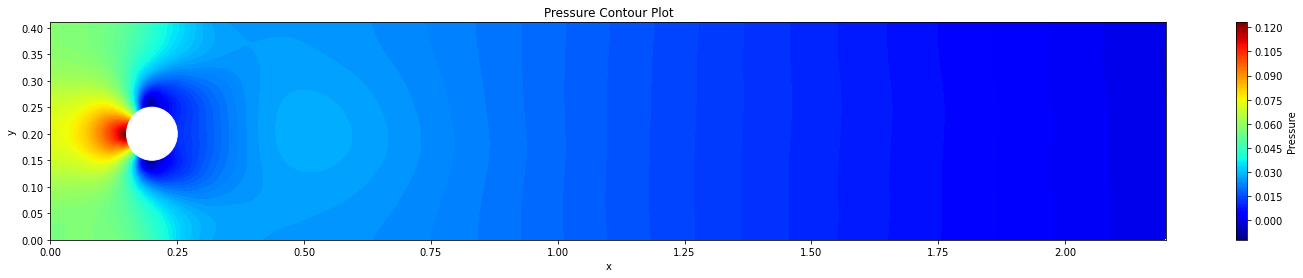

In [77]:
# Convert tensors to numpy arrays
x = x_test.detach().cpu().numpy().squeeze()
y = y_test.detach().cpu().numpy().squeeze()
z = p_pred.detach().cpu().numpy().squeeze()  # Prediction values

circle = plt.Circle((0.2, 0.2), 0.05, color="white", zorder=10)
fig, ax = plt.subplots(figsize=(25, 4))
contour = ax.tricontourf(x, y, z, levels=100, cmap="jet")
plt.colorbar(contour, label="Pressure")
ax.add_patch(circle)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Pressure Contour Plot")
plt.show()

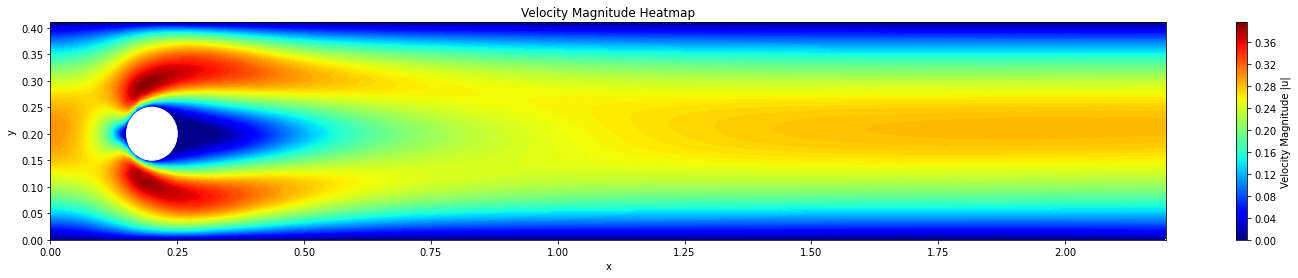

In [ ]:
v_pred = -1*grad(psi_pred, inputs, torch.ones_like(psi_pred), create_graph=True)[0][:, 0:1]  # du/dx
u_pred = grad(psi_pred, inputs, torch.ones_like(psi_pred), create_graph=True)[0][:, 1:2]  # du/dy
velocity_magnitude = torch.sqrt(u_pred**2 + v_pred**2)

x_np = x_test.detach().cpu().numpy().flatten()
y_np = y_test.detach().cpu().numpy().flatten()
vel_mag_np = velocity_magnitude.detach().cpu().numpy().flatten()

circle = plt.Circle((0.2, 0.2), 0.05, color="white", zorder=10)

fig, ax = plt.subplots(figsize=(25, 4))
contour = ax.tricontourf(x_np, y_np, vel_mag_np, levels=100, cmap="jet")
plt.colorbar(contour, label="Velocity Magnitude |u|")
ax.add_patch(circle)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Velocity Magnitude Heatmap")
plt.show()

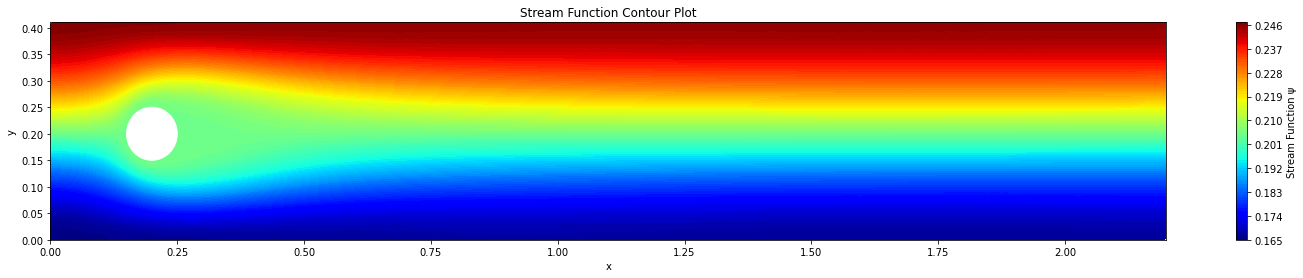

In [75]:
psi_np = psi_pred.detach().cpu().numpy().flatten()

circle = plt.Circle((0.2, 0.2), 0.05, color="white", zorder=10)
fig, ax = plt.subplots(figsize=(25, 4))
contour = ax.tricontourf(x_np, y_np, psi_np, levels=100, cmap="jet")
plt.colorbar(contour, label="Stream Function ψ")
ax.add_patch(circle)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Stream Function Contour Plot")
plt.show()